# Spaceship Titanic - V4 (V2 Base + Surgical EDA Features)

**V1:** CV 0.8265 / LB 0.8020 (overfitting, 49 features)  
**V2:** CV 0.8141 / LB 0.8071 (clean, 29 features, gap 0.007)  
**V3:** CV 0.8184 / LB 0.8041 (overfit, 56 features, target encoding)  
**V4 Goal:** V2 base + ONLY simple, robust EDA features  

**What went wrong in V3:**
- Target encoding on 8700 rows = overfit even with CV-safe
- Too many interaction label encodings (high cardinality)
- 56 features = noise > signal ratio too high
- Slightly weaker regularization than V2

**V4 changes from V2:**
- Smart imputation from EDA (HomePlanet←Deck mapping)
- +IsBaby (81% transported), +Awake_NoSpend (62% transported)
- +n_missing (data quality signal)
- +DeckSide_freq ONLY (frequency, NOT target/label encoding)
- Same strong regularization as V2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings, os

warnings.filterwarnings('ignore')

SEED = 42
N_FOLDS = 10
TARGET = 'Transported'

def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()
print('V4 Setup complete.')

V4 Setup complete.


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

# Save original for n_missing computation
train_orig_nulls = train.isnull().sum(axis=1)
test_orig_nulls = test.isnull().sum(axis=1)

train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan
df = pd.concat([train, test], axis=0, ignore_index=True)

# n_missing from original data (before any imputation)
df['n_missing'] = pd.concat([train_orig_nulls, test_orig_nulls], ignore_index=True)

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print(f'Combined: {df.shape}')

Combined: (12970, 16)


## Feature Engineering V4 - V2 Base + Surgical Additions

In [3]:
# === STEP 1: Parse raw columns (same as V2) ===
df['_Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
df['GroupSize'] = df.groupby('_Group')['PassengerId'].transform('count')
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

# Cabin
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
df['Side'] = df['Cabin'].str.split('/').str[2]
df['CabinRegion'] = (df['CabinNum'] // 100).astype(float)

# Name
df['Surname'] = df['Name'].str.split().str[-1]
df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
df.loc[df['Surname'].isna(), 'FamilySize'] = 1

# Booleans
df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})

print('Step 1 done: parsing')

Step 1 done: parsing


In [4]:
# === STEP 2: Smart imputation (IMPROVED from EDA) ===

# CryoSleep passengers have 0 spending
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0

# Infer CryoSleep from spending
total_spend_raw = df[spend_cols].sum(axis=1)
df.loc[(df['CryoSleep'].isna()) & (total_spend_raw == 0), 'CryoSleep'] = 1
df.loc[(df['CryoSleep'].isna()) & (total_spend_raw > 0), 'CryoSleep'] = 0

# NEW in V4: HomePlanet inferred from Deck (EDA: deterministic mapping)
deck_to_planet = {
    'A': 'Europa', 'B': 'Europa', 'C': 'Europa', 'T': 'Europa',
    'G': 'Earth'
}
for deck, planet in deck_to_planet.items():
    mask = (df['HomePlanet'].isna()) & (df['Deck'] == deck)
    df.loc[mask, 'HomePlanet'] = planet

# Fill remaining
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

print(f'Step 2 done: smart imputation. Nulls: {df.isnull().sum().sum()}')

Step 2 done: smart imputation. Nulls: 0


In [5]:
# === STEP 3: Spending features (V2 base) ===
df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)

for col in spend_cols:
    df[f'{col}_log'] = np.log1p(df[col])

# Luxury vs basic (V2)
df['LuxurySpend'] = np.log1p(df['Spa'] + df['VRDeck'] + df['RoomService'])
df['BasicSpend'] = np.log1p(df['FoodCourt'] + df['ShoppingMall'])

# NEW V4: Awake_NoSpend (EDA: 62% transported)
df['Awake_NoSpend'] = ((df['CryoSleep'] == 0) & (df['TotalSpend'] == 0)).astype(int)

print('Step 3 done: spending features')

Step 3 done: spending features


In [6]:
# === STEP 4: Age features (V2 base + 1 EDA addition) ===
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 5, 12, 18, 30, 50, 80],
                        labels=[0, 1, 2, 3, 4, 5]).astype(float)
df['IsChild'] = (df['Age'] < 18).astype(float)

# NEW V4: IsBaby (EDA: 81% transported - strong signal)
df['IsBaby'] = (df['Age'] <= 4).astype(float)

print('Step 4 done: age features')

Step 4 done: age features


In [7]:
# === STEP 5: Interaction (V2) ===
df['CryoSleep_NoSpend'] = ((df['CryoSleep'] == 1) & (df['TotalSpend'] == 0)).astype(int)

# === STEP 6: Group-level spending (V2) ===
df['GroupSpend_mean'] = df.groupby('_Group')['TotalSpend'].transform('mean')
df['GroupSpend_mean_log'] = np.log1p(df['GroupSpend_mean'])

print('Step 5-6 done: interactions & group features')

Step 5-6 done: interactions & group features


In [8]:
# === STEP 7: Encode categoricals (V2 base) ===
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col].astype(str))

for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

# NEW V4: DeckSide frequency ONLY (no label/target encoding)
df['DeckSide'] = df['Deck'] + '_' + df['Side']
freq = df['DeckSide'].value_counts(normalize=True)
df['DeckSide_freq'] = df['DeckSide'].map(freq)

print('Step 7 done: encoding')

Step 7 done: encoding


In [9]:
# === DEFINE FEATURES ===
drop_cols = [
    'PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
    'HomePlanet', 'Destination', 'Deck', 'Side', 'DeckSide',
    '_Group', 'CabinNum',
    'TotalSpend', 'GroupSpend_mean',
] + spend_cols

features = [c for c in df.columns if c not in drop_cols]
print(f'V4 features: {len(features)}')
print()
for i, f in enumerate(sorted(features)):
    print(f'  {i+1:2d}. {f}')

V4 features: 33

   1. Age
   2. AgeGroup
   3. Awake_NoSpend
   4. BasicSpend
   5. CabinRegion
   6. CryoSleep
   7. CryoSleep_NoSpend
   8. DeckSide_freq
   9. Deck_freq
  10. Deck_le
  11. Destination_freq
  12. Destination_le
  13. FamilySize
  14. FoodCourt_log
  15. GroupSize
  16. GroupSpend_mean_log
  17. HomePlanet_freq
  18. HomePlanet_le
  19. IsAlone
  20. IsBaby
  21. IsChild
  22. LuxurySpend
  23. NoSpend
  24. NumServicesUsed
  25. RoomService_log
  26. ShoppingMall_log
  27. Side_freq
  28. Side_le
  29. Spa_log
  30. TotalSpend_log
  31. VIP
  32. VRDeck_log
  33. n_missing


In [10]:
# Split
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].astype(int).values
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')
print(f'Target mean: {np.mean(y):.4f}')

X: (8693, 33), y: (8693,), X_test: (4277, 33)
Target mean: 0.5036


## LightGBM V4 (V2 regularization)

In [11]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 20,
    'learning_rate': 0.03,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_child_samples': 30,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'max_depth': 5,
    'n_estimators': 5000,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': SEED,
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
fi_lgb = np.zeros(len(features))

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)]
    )
    
    oof_lgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    fi_lgb += model.feature_importances_ / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_lgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
print(f'\nLightGBM V4 CV: {lgb_acc:.5f}')

Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.386017
Early stopping, best iteration is:
[465]	valid_0's binary_logloss: 0.385209
Fold 1/10 - Accuracy: 0.80575
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.361232
Early stopping, best iteration is:
[664]	valid_0's binary_logloss: 0.359434


Fold 2/10 - Accuracy: 0.82989
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.361203
Fold 3/10 - Accuracy: 0.82299
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.41975
Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 0.418585
Fold 4/10 - Accuracy: 0.78481
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.363391
Early stopping, best iteration is:
[477]	valid_0's binary_logloss: 0.361864
Fold 5/10 - Accuracy: 0.83199
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.370599
Early stopping, best iteration is:
[605]	valid_0's binary_logloss: 0.368282
Fold 6/10 - Accuracy: 0.83084
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.362693
Early stopping, best iteration is:
[384]	valid_0's binary_logloss: 0.358761
Fold 7/10 - Accuracy: 0.82854
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.368655
Early stopping, best iteration is:
[462]	valid_0's binary_logloss: 0.367825
Fold 8/10 - Accuracy: 0.81128
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.389604
Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.388499
Fold 9/10 - Accuracy: 0.80667
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.401804
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.399702
Fold 10/10 - Accuracy: 0.79517

LightGBM V4 CV: 0.81479


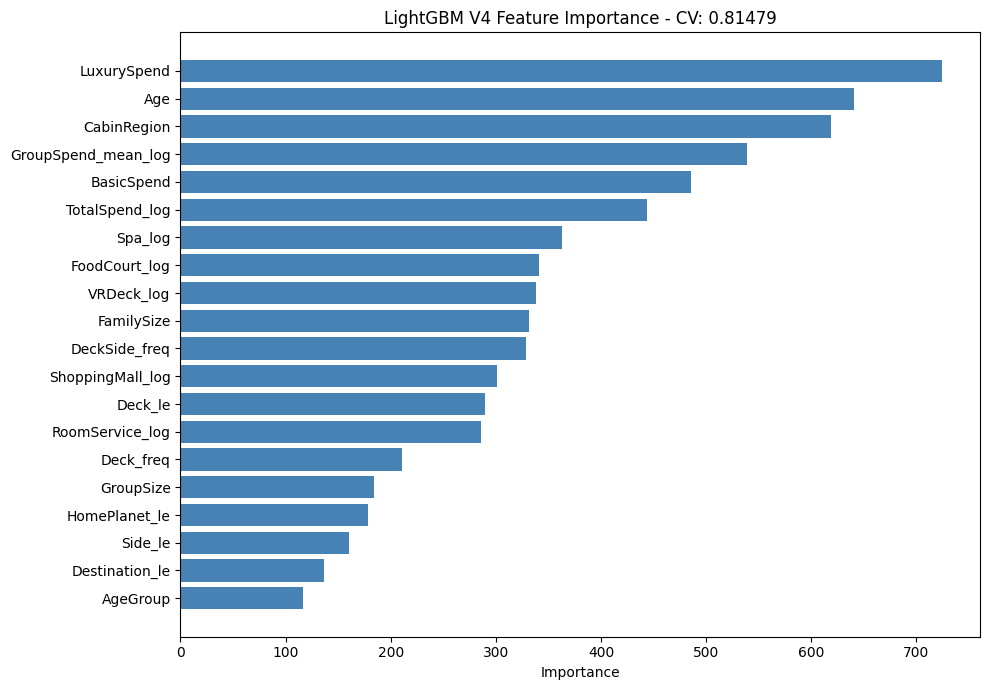

In [12]:
# Feature importance
fi_df = pd.DataFrame({'feature': features, 'importance': fi_lgb})
fi_df = fi_df.sort_values('importance', ascending=True).tail(20)

plt.figure(figsize=(10, 7))
plt.barh(fi_df['feature'], fi_df['importance'], color='steelblue')
plt.title(f'LightGBM V4 Feature Importance - CV: {lgb_acc:.5f}')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## XGBoost V4 (V2 regularization)

In [13]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 10,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'gamma': 0.1,
    'n_estimators': 5000,
    'early_stopping_rounds': 200,
    'tree_method': 'hist',
    'random_state': SEED,
    'verbosity': 0,
}

oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=500)
    
    oof_xgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_xgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
print(f'\nXGBoost V4 CV: {xgb_acc:.5f}')

[0]	validation_0-logloss:0.68144


[500]	validation_0-logloss:0.39134

[805]	validation_0-logloss:0.39028


Fold 1/10 - Accuracy: 0.79885
[0]	validation_0-logloss:0.68079


[500]	validation_0-logloss:0.36520

[771]	validation_0-logloss:0.36459


Fold 2/10 - Accuracy: 0.82299
[0]	validation_0-logloss:0.68044


[500]	validation_0-logloss:0.36001


[724]	validation_0-logloss:0.36015


Fold 3/10 - Accuracy: 0.82759
[0]	validation_0-logloss:0.68211


[500]	validation_0-logloss:0.42343


[1000]	validation_0-logloss:0.42137


[1069]	validation_0-logloss:0.42085


Fold 4/10 - Accuracy: 0.78366
[0]	validation_0-logloss:0.68076


[500]	validation_0-logloss:0.36368


[1000]	validation_0-logloss:0.36034

[1256]	validation_0-logloss:0.36108


Fold 5/10 - Accuracy: 0.83314
[0]	validation_0-logloss:0.68153


[500]	validation_0-logloss:0.37941

[909]	validation_0-logloss:0.37765


Fold 6/10 - Accuracy: 0.82394
[0]	validation_0-logloss:0.68123


[500]	validation_0-logloss:0.36158


[832]	validation_0-logloss:0.36256


Fold 7/10 - Accuracy: 0.81933
[0]	validation_0-logloss:0.68070


[500]	validation_0-logloss:0.37240

[854]	validation_0-logloss:0.37019


Fold 8/10 - Accuracy: 0.81243
[0]	validation_0-logloss:0.68095


[500]	validation_0-logloss:0.39391

[551]	validation_0-logloss:0.39348


Fold 9/10 - Accuracy: 0.80667
[0]	validation_0-logloss:0.68154


[500]	validation_0-logloss:0.40468


[715]	validation_0-logloss:0.40465


Fold 10/10 - Accuracy: 0.79402

XGBoost V4 CV: 0.81226


## CatBoost V4 (V2 regularization)

In [14]:
oof_cb = np.zeros(len(X))
test_cb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.03,
        depth=4,
        l2_leaf_reg=5.0,
        subsample=0.7,
        colsample_bylevel=0.7,
        min_data_in_leaf=30,
        random_seed=SEED,
        verbose=500,
        early_stopping_rounds=200,
        task_type='CPU',
    )
    
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    
    oof_cb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_cb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
print(f'\nCatBoost V4 CV: {cb_acc:.5f}')

0:	learn: 0.6788046	test: 0.6785148	best: 0.6785148 (0)	total: 148ms	remaining: 12m 19s


500:	learn: 0.3548476	test: 0.3894508	best: 0.3894508 (500)	total: 944ms	remaining: 8.48s


1000:	learn: 0.3176226	test: 0.3819904	best: 0.3819240 (995)	total: 1.69s	remaining: 6.75s


1500:	learn: 0.2910934	test: 0.3808334	best: 0.3804035 (1458)	total: 2.44s	remaining: 5.68s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3803795248
bestIteration = 1627

Shrink model to first 1628 iterations.
Fold 1/10 - Accuracy: 0.80460
0:	learn: 0.6790921	test: 0.6782233	best: 0.6782233 (0)	total: 2.29ms	remaining: 11.5s


500:	learn: 0.3574232	test: 0.3636949	best: 0.3636949 (500)	total: 743ms	remaining: 6.67s


1000:	learn: 0.3192987	test: 0.3569782	best: 0.3568816 (985)	total: 1.49s	remaining: 5.95s


1500:	learn: 0.2911605	test: 0.3546102	best: 0.3542567 (1438)	total: 2.24s	remaining: 5.23s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3537627515
bestIteration = 1673

Shrink model to first 1674 iterations.
Fold 2/10 - Accuracy: 0.83218
0:	learn: 0.6788693	test: 0.6782564	best: 0.6782564 (0)	total: 1.53ms	remaining: 7.67s


500:	learn: 0.3564829	test: 0.3620935	best: 0.3619381 (498)	total: 740ms	remaining: 6.65s


1000:	learn: 0.3175993	test: 0.3550067	best: 0.3549333 (978)	total: 1.5s	remaining: 5.98s


1500:	learn: 0.2898427	test: 0.3539754	best: 0.3536500 (1394)	total: 2.26s	remaining: 5.27s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3536499953
bestIteration = 1394

Shrink model to first 1395 iterations.


Fold 3/10 - Accuracy: 0.82414
0:	learn: 0.6778861	test: 0.6804306	best: 0.6804306 (0)	total: 2.69ms	remaining: 13.5s


500:	learn: 0.3509784	test: 0.4239929	best: 0.4239868 (498)	total: 744ms	remaining: 6.68s


1000:	learn: 0.3135696	test: 0.4178617	best: 0.4175429 (980)	total: 1.49s	remaining: 5.94s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4173992379
bestIteration = 1017

Shrink model to first 1018 iterations.
Fold 4/10 - Accuracy: 0.78251
0:	learn: 0.6792940	test: 0.6787088	best: 0.6787088 (0)	total: 3.53ms	remaining: 17.6s


500:	learn: 0.3558964	test: 0.3652215	best: 0.3652215 (500)	total: 777ms	remaining: 6.98s


1000:	learn: 0.3181890	test: 0.3615391	best: 0.3613912 (989)	total: 1.53s	remaining: 6.1s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3602796957
bestIteration = 1165

Shrink model to first 1166 iterations.
Fold 5/10 - Accuracy: 0.83314
0:	learn: 0.6784662	test: 0.6792119	best: 0.6792119 (0)	total: 1.9ms	remaining: 9.48s


500:	learn: 0.3524193	test: 0.3914881	best: 0.3914881 (500)	total: 767ms	remaining: 6.89s


1000:	learn: 0.3170829	test: 0.3861399	best: 0.3858606 (943)	total: 1.52s	remaining: 6.08s


1500:	learn: 0.2900886	test: 0.3848698	best: 0.3845052 (1369)	total: 2.4s	remaining: 5.61s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3845051882
bestIteration = 1369

Shrink model to first 1370 iterations.
Fold 6/10 - Accuracy: 0.81243
0:	learn: 0.6785736	test: 0.6790153	best: 0.6790153 (0)	total: 8.34ms	remaining: 41.7s


500:	learn: 0.3585191	test: 0.3632205	best: 0.3631471 (499)	total: 1.64s	remaining: 14.7s


1000:	learn: 0.3205111	test: 0.3548714	best: 0.3548714 (1000)	total: 3.19s	remaining: 12.8s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.353916293
bestIteration = 1202

Shrink model to first 1203 iterations.
Fold 7/10 - Accuracy: 0.83544
0:	learn: 0.6788700	test: 0.6789218	best: 0.6789218 (0)	total: 6.57ms	remaining: 32.8s


500:	learn: 0.3546377	test: 0.3761532	best: 0.3761532 (500)	total: 1.65s	remaining: 14.8s


1000:	learn: 0.3170070	test: 0.3707687	best: 0.3706920 (966)	total: 3.26s	remaining: 13s


1500:	learn: 0.2904358	test: 0.3685034	best: 0.3680387 (1479)	total: 4.84s	remaining: 11.3s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3676585142
bestIteration = 1642

Shrink model to first 1643 iterations.
Fold 8/10 - Accuracy: 0.80898
0:	learn: 0.6795176	test: 0.6793067	best: 0.6793067 (0)	total: 4.41ms	remaining: 22s


500:	learn: 0.3529788	test: 0.3908695	best: 0.3904773 (470)	total: 1.61s	remaining: 14.4s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3886116564
bestIteration = 756

Shrink model to first 757 iterations.
Fold 9/10 - Accuracy: 0.81243
0:	learn: 0.6786156	test: 0.6791700	best: 0.6791700 (0)	total: 1.72ms	remaining: 8.58s


500:	learn: 0.3527519	test: 0.4071068	best: 0.4070774 (499)	total: 766ms	remaining: 6.88s


1000:	learn: 0.3158250	test: 0.3990394	best: 0.3990270 (998)	total: 1.53s	remaining: 6.13s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3979832429
bestIteration = 1146

Shrink model to first 1147 iterations.
Fold 10/10 - Accuracy: 0.79862

CatBoost V4 CV: 0.81445


## Ensemble & Submission

In [15]:
print('=== V4 Results ===')
print(f'LightGBM: {lgb_acc:.5f}')
print(f'XGBoost:  {xgb_acc:.5f}')
print(f'CatBoost: {cb_acc:.5f}')

# Simple average
oof_avg = (oof_lgb + oof_xgb + oof_cb) / 3
avg_acc = accuracy_score(y, (oof_avg > 0.5).astype(int))
print(f'\nSimple Average: {avg_acc:.5f}')

# Majority voting
votes = ((oof_lgb > 0.5).astype(int) + (oof_xgb > 0.5).astype(int) + (oof_cb > 0.5).astype(int))
vote_acc = accuracy_score(y, (votes >= 2).astype(int))
print(f'Majority Voting: {vote_acc:.5f}')

# Use simple average for submission
final_proba = (test_lgb + test_xgb + test_cb) / 3
final_preds = (final_proba > 0.5)

print(f'\nTest: {final_preds.sum()} True / {len(final_preds) - final_preds.sum()} False')
print(f'Ratio: {final_preds.mean():.4f}')

print(f'\n=== VERSION COMPARISON ===')
print(f'V1: CV 0.82653 | LB 0.80196 | Gap 0.0246 | 49 features')
print(f'V2: CV 0.81410 | LB 0.80710 | Gap 0.0070 | 29 features')
print(f'V3: CV 0.81836 | LB 0.80406 | Gap 0.0143 | 56 features')
print(f'V4: CV {avg_acc:.5f} | LB TBD     |            | {len(features)} features')

=== V4 Results ===
LightGBM: 0.81479
XGBoost:  0.81226
CatBoost: 0.81445

Simple Average: 0.81456
Majority Voting: 0.81422

Test: 2224 True / 2053 False
Ratio: 0.5200

=== VERSION COMPARISON ===
V1: CV 0.82653 | LB 0.80196 | Gap 0.0246 | 49 features
V2: CV 0.81410 | LB 0.80710 | Gap 0.0070 | 29 features
V3: CV 0.81836 | LB 0.80406 | Gap 0.0143 | 56 features
V4: CV 0.81456 | LB TBD     |            | 33 features


In [16]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_preds
})
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('../submissions/submission_v4.csv', index=False)

assert submission.shape[0] == sample_sub.shape[0]
assert list(submission.columns) == list(sample_sub.columns)
assert submission['Transported'].dtype == bool

print('V4 Submission saved: submissions/submission_v4.csv')
print(submission['Transported'].value_counts(normalize=True))
submission.head()

V4 Submission saved: submissions/submission_v4.csv
Transported
True     0.519991
False    0.480009
Name: proportion, dtype: float64


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
